# SAS 해커톤에 쓰일 dummy data maker

In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=10)
from faker import Faker
fake_ko = Faker('ko_KR')

import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from collections import defaultdict

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# 폰트 설정
from matplotlib import font_manager, rc
font_name = "Malgun Gothic"  # 나눔고딕 폰트 이름 (이미 설치되어 있다고 가정)

rc('font', family=font_name)
# 그래프에 마이너스 폰트 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False



In [3]:
# 데이터는 총 num_samples 개
## 수급자
num_samples = 100007
## 부당비율 3% 가정
fraud_ratio = int(0.03 * num_samples)
## 종사자

## 기관


#### get data

In [4]:
## 주소 index 생성
address = pd.read_csv('./gps_data/merged_output.csv')

prs = pd.read_csv('./prs_dummy_data.csv')

with open('gps_noise.pkl', 'rb') as f:
    noise = pickle.load(f)


In [5]:
prs

,Unnamed: 0,ID,LTC_ID,NM,GRADE,BIRTHDAY_0,ADDRESS_SIDO_NM,ADDRESS_INDEX,GPS_BASE_X,GPS_BASE_Y
0,0,L160034205,3-86247-00028,김너주,3,1934-04-07,강원특별자치도,135415,128.023627,37.721240
1,1,L110018660,2-86247-00111,이터빌,3,1944-03-23,강원특별자치도,200593,128.020061,38.176570
2,2,L090088482,3-86247-00207,박돌보,3,1940-01-10,강원특별자치도,536,127.674917,37.838683
3,3,L210048725,3-86247-00034,류조산,5,1932-06-28,강원특별자치도,187512,127.404210,38.277389
4,4,L210051942,3-86247-00186,서춤논,4,1946-05-03,강원특별자치도,179318,128.702571,37.470652
...,...,...,...,...,...,...,...,...,...,...
99995,99995,L130031750,2-15591-00046,김놀펄,4,1951-05-24,충청북도,3554944,127.537532,36.659409
99996,99996,L180014004,2-11674-00561,최딩비,5,1945-05-31,충청북도,3645986,127.590550,36.973971
99997,99997,L080074648,3-15591-00056,김처두,1,1941-07-08,충청북도,3602226,128.205037,37.097820
99998,99998,L180046596,2-15591-00070,이훈시,5,1939-05-11,충청북도,3574815,127.834434,36.947349


In [8]:
noise, noise.shape

(array([[[-4.14880149e-01,  1.29277168e-01],
         [-1.78046201e+00, -1.26020680e+00],
         [-1.14522807e+00,  1.59624824e+00],
         ...,
         [ 6.55309577e-02, -1.13681076e+00],
         [ 4.42690318e-01, -9.89969314e-01],
         [-7.92164836e-01,  1.06009953e+00]],
 
        [[-3.66023026e-01, -5.79066179e-01],
         [-5.12975506e-02, -3.53199700e-01],
         [ 9.99005987e-01, -7.45344775e-01],
         ...,
         [-2.53314315e-01,  7.73822808e-01],
         [ 2.54950270e-01, -5.94807082e-02],
         [ 6.78422320e-01,  1.15935632e+00]],
 
        [[ 9.89946284e-01, -2.85641745e+00],
         [ 2.21110946e-01,  2.65934251e-01],
         [-6.81751542e-03, -1.90115266e-01],
         ...,
         [ 8.77276046e-01, -3.03161371e-01],
         [ 3.37085740e-01,  2.67189158e+00],
         [ 1.87710082e+00,  2.35469883e+00]],
 
        ...,
 
        [[ 6.71060273e-02, -4.55045979e-01],
         [-2.04121116e+00, -2.34873536e-01],
         [-5.55465015e-01,  9.9821

In [9]:
# 위도, 경도에 미터당 차이
lat_per_meter = 0.0000449  # 1m 당 위도 차이
lon_per_meter = 0.0000563  # 서울 기준 1m 당 경도 차이

lat_per_50m = lat_per_meter * 50  # 1m 당 위도 차이
lon_per_50m = lon_per_meter * 50 # 서울 기준 1m 당 경도 차이
#50m 이내의 gps noise, 전체에 대해서 100개씩 생성해보기.
#1을 50m로 설정.

In [12]:
# Calculate the noise in terms of GPS coordinates with proper scaling for latitude and longitude
gps_noise_x_adjusted = noise[:, :, 0] * lon_per_50m  # For longitude
gps_noise_y_adjusted = noise[:, :, 1] * lat_per_50m  # For latitude

# Generate noisy GPS data by adding the scaled noise to the base GPS coordinates
gps_x_adjusted = prs['GPS_BASE_X'].values[:, None] + gps_noise_x_adjusted
gps_y_adjusted = prs['GPS_BASE_Y'].values[:, None] + gps_noise_y_adjusted

# Create a DataFrame for the adjusted noisy GPS data
gps_data = pd.DataFrame({
    'ID': np.repeat(prs['ID'].values, gps_x_adjusted.shape[1]),
    'gps_x': gps_x_adjusted.flatten(),
    'gps_y': gps_y_adjusted.flatten()
})

In [13]:
gps_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ID      object 
 1   gps_x   float64
 2   gps_y   float64
dtypes: float64(2), object(1)
memory usage: 228.9+ MB


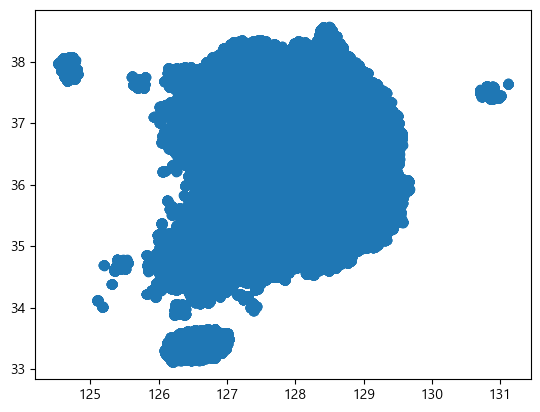

In [15]:
plt.scatter(gps_data.gps_x, gps_data.gps_y)

In [17]:
gps_data.to_csv('gps_dummy_data.csv')

In [2]:
df = pd.read_csv('gps_dummy_data.csv')

In [3]:
df

,Unnamed: 0,ID,gps_x,gps_y
0,0,L160034205,128.022459,37.721530
1,1,L160034205,128.018615,37.718411
2,2,L160034205,128.020403,37.724824
3,3,L160034205,128.024435,37.722888
4,4,L160034205,128.025934,37.718700
...,...,...,...,...
9999995,9999995,L140085933,127.706358,36.513800
9999996,9999996,L140085933,127.707314,36.509975
9999997,9999997,L140085933,127.701564,36.513739
9999998,9999998,L140085933,127.708819,36.516229


In [ ]:
target = df[df.ID == 'L200048518']
plt.scatter(target.gps_x, target.gps_y)


#### 여기서부터는 analysis로 옮기기

In [10]:
# 중심 좌표에서 거리를 계산하고 그 거리들의 평균과 표준편차를 반환하는 함수

def dist_mean_std(df, x_col, y_col):
    # 중심 좌표 (x, y) 계산
    center_x = df[x_col].mean()
    center_y = df[y_col].mean()
    
    # 중심 좌표로부터 각 점까지의 거리 계산
    distances = np.sqrt((df[x_col] - center_x)**2 + (df[y_col] - center_y)**2)
    
    # 거리들의 평균과 표준편차 계산
    dist_mean = distances.mean()
    dist_std = distances.std()
    
    return pd.Series({'dist_mean': dist_mean, 'dist_std': dist_std})

In [12]:
# groupby로 각 id별 dist_mean과 dist_std 계산
result = df.groupby('ID').apply(lambda group: dist_mean_std(group, 'gps_x', 'gps_y')).reset_index()
result

TypeError: DataFrame.groupby() got an unexpected keyword argument 'include_groups'

In [13]:
result = df.groupby('ID').apply(lambda group: dist_mean_std(group[['gps_x', 'gps_y']], 'gps_x', 'gps_y')).reset_index()


C:\Users\pooko\AppData\Local\Temp\ipykernel_22688\3331803690.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('ID').apply(lambda group: dist_mean_std(group[['gps_x', 'gps_y']], 'gps_x', 'gps_y')).reset_index()


In [14]:
result

,ID,dist_mean,dist_std
0,L080000002,0.003337,0.001503
1,L080000007,0.003100,0.001561
2,L080000071,0.003303,0.001543
3,L080000077,0.002814,0.001820
4,L080000109,0.003070,0.001569
...,...,...,...
99995,L240199962,0.003021,0.001518
99996,L240220634,0.002943,0.001688
99997,L240245999,0.003241,0.001792
99998,L240253203,0.002979,0.001784


In [18]:
result.dist_std.max(), result.dist_std.min()

(0.02609842482701773, 0.0008141432876000083)

In [19]:
top_10_dist_std = result.nlargest(10, 'dist_std')

In [20]:
top_10_dist_std

,ID,dist_mean,dist_std
78849,L210043083,0.030051,0.026098
32940,L130063281,0.020775,0.025657
69585,L190085520,0.033879,0.024200
80822,L210078257,0.025350,0.023572
33696,L130076220,0.019420,0.023286
21855,L110073195,0.022963,0.022424
57504,L170078433,0.022746,0.021679
89031,L230014253,0.024077,0.021426
65553,L190014009,0.026134,0.021396
29087,L120100150,0.027183,0.021211


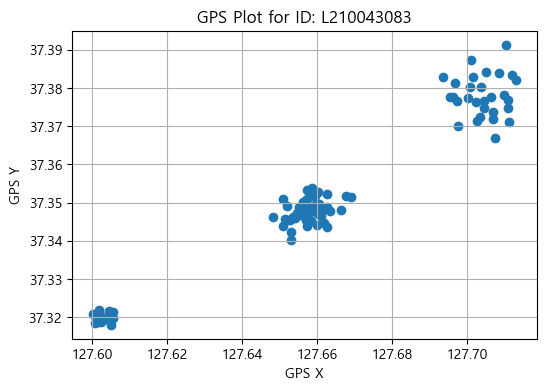

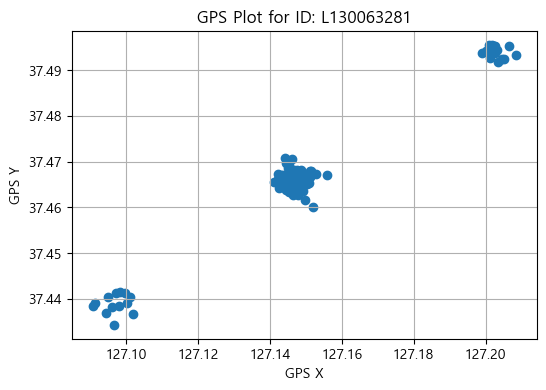

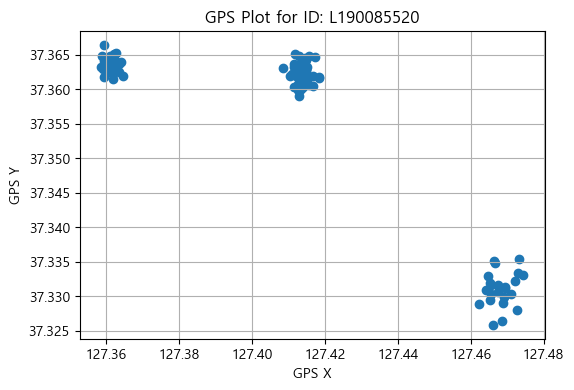

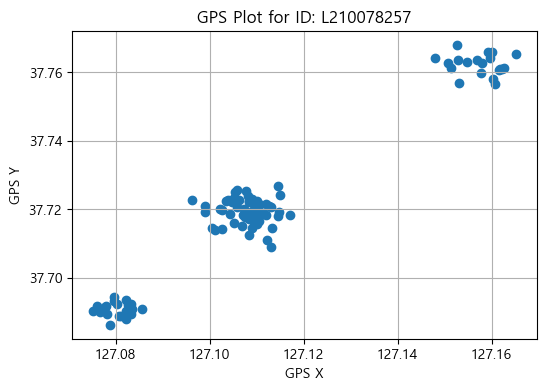

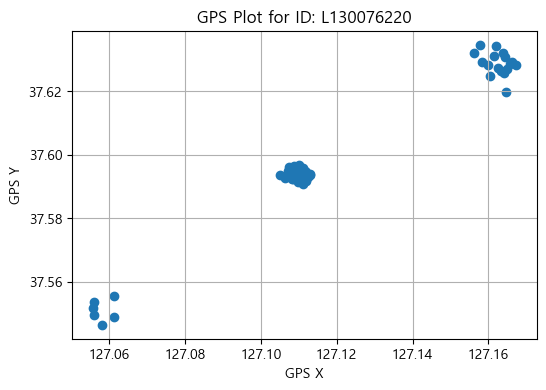

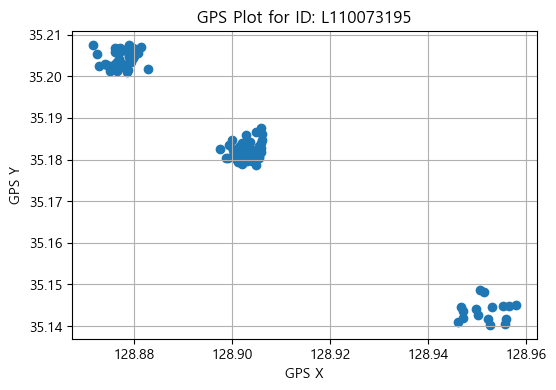

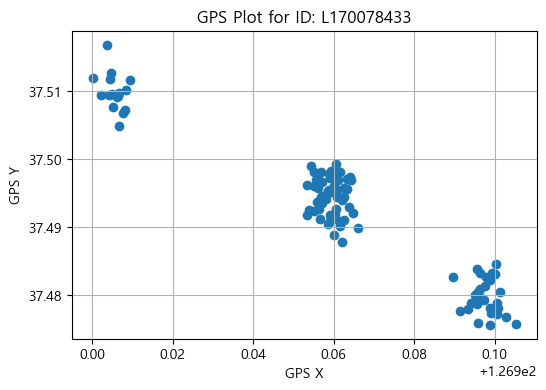

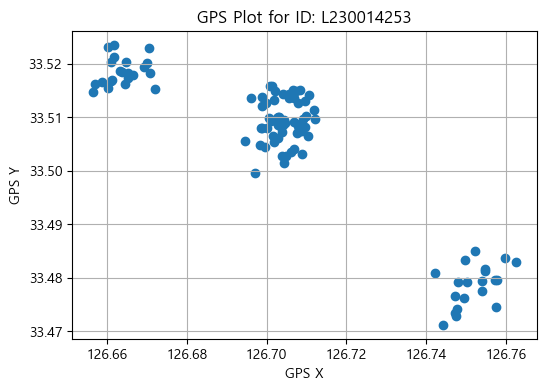

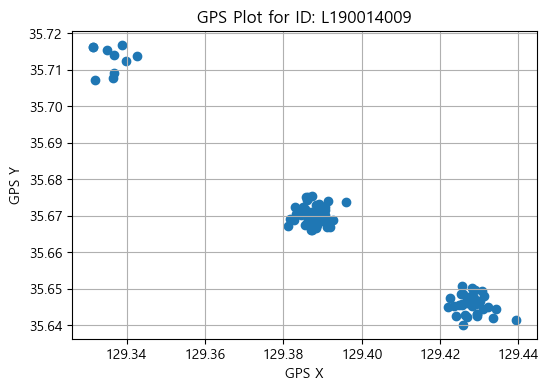

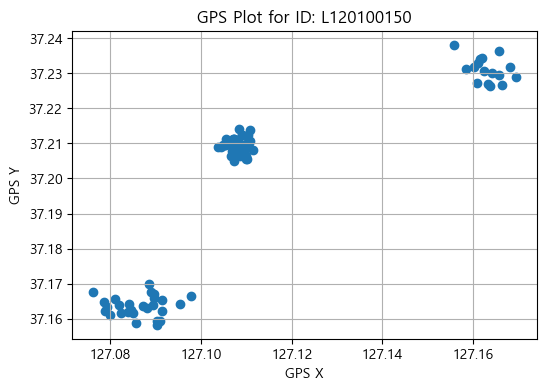

In [21]:
for id_val in top_10_dist_std.ID:
    subset = df[df['ID'] == id_val]
    
    plt.figure(figsize=(6, 4))
    plt.scatter(subset['gps_x'], subset['gps_y'])
    plt.title(f'GPS Plot for ID: {id_val}')
    plt.xlabel('GPS X')
    plt.ylabel('GPS Y')
    plt.grid(True)
    
    # 그래프 출력
    plt.show()

In [22]:
result

,ID,dist_mean,dist_std
0,L080000002,0.003337,0.001503
1,L080000007,0.003100,0.001561
2,L080000071,0.003303,0.001543
3,L080000077,0.002814,0.001820
4,L080000109,0.003070,0.001569
...,...,...,...
99995,L240199962,0.003021,0.001518
99996,L240220634,0.002943,0.001688
99997,L240245999,0.003241,0.001792
99998,L240253203,0.002979,0.001784


In [23]:
# dist_mean과 dist_std의 평균과 표준편차를 사용해 Z-스코어로 표준화
result['mean_zscore'] = (result['dist_mean'] - result['dist_mean'].mean()) / result['dist_mean'].std()
result['std_zscore'] = (result['dist_std'] - result['dist_std'].mean()) / result['dist_std'].std()
result

,ID,dist_mean,dist_std,mean_zscore,std_zscore
0,L080000002,0.003337,0.001503,-0.077025,-0.280475
1,L080000007,0.003100,0.001561,-0.176153,-0.235577
2,L080000071,0.003303,0.001543,-0.091470,-0.249572
3,L080000077,0.002814,0.001820,-0.295697,-0.033939
4,L080000109,0.003070,0.001569,-0.188606,-0.229310
...,...,...,...,...,...
99995,L240199962,0.003021,0.001518,-0.209396,-0.269061
99996,L240220634,0.002943,0.001688,-0.241887,-0.136469
99997,L240245999,0.003241,0.001792,-0.117498,-0.055565
99998,L240253203,0.002979,0.001784,-0.226684,-0.061901


In [26]:
result.std_zscore.max(), result.std_zscore.min(), result.std_zscore.mean()

(18.845875131979227, -0.8162688009674216, -3.552713678800501e-19)

In [27]:
result.dist_std.max(), result.dist_std.min(), result.dist_std.mean()

(0.02609842482701773, 0.0008141432876000083, 0.0018638136717599011)

In [3]:
# DBSCAN 기법을 사용한 군집화 함수
def apply_dbscan(df, eps_value=0.01, min_samples_value=5):
    # 좌표 데이터를 위한 DBSCAN 모델 적용
    db = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(df[['gps_x', 'gps_y']])
    
    # 군집 레이블 추가 (군집이 없는 경우 -1로 표시)
    df['cluster'] = db.labels_
    
    # 군집의 신뢰성을 평가하기 위한 실루엣 점수 계산
    # 군집이 2개 이상이어야 silhouette_score 계산 가능
    if len(set(db.labels_)) > 1:
        score = silhouette_score(df[['gps_x', 'gps_y']], db.labels_)
    else:
        score = -1  # 신뢰성을 계산할 수 없을 때
    df['s_score'] = score

    return df, score


In [4]:
# 집단이 2개 이상이고 신뢰성이 높은 ID를 찾는 함수
def find_reliable_clusters(data, eps=0.01, min_samples=5, score_threshold=0.5):
    reliable_ids = []
    
    for id_val, group in data.groupby('ID'):
        clustered_data, score = apply_dbscan(group, eps_value=eps, min_samples_value=min_samples)
        
        # 클러스터가 2개 이상이면서 신뢰성이 높은 데이터 선택
        if len(set(clustered_data['cluster'])) > 1 and score > score_threshold:
            reliable_ids.append((id_val, score))
    
    return reliable_ids

In [5]:
gps_data = pd.read_csv('gps_dummy_data.csv')
gps_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   ID          object 
 2   gps_x       float64
 3   gps_y       float64
dtypes: float64(2), int64(1), object(1)
memory usage: 305.2+ MB


In [11]:
gps_sample = gps_data.iloc[:1000,:]
gps_sample

,Unnamed: 0,ID,gps_x,gps_y
0,0,L160034205,128.022459,37.721530
1,1,L160034205,128.018615,37.718411
2,2,L160034205,128.020403,37.724824
3,3,L160034205,128.024435,37.722888
4,4,L160034205,128.025934,37.718700
...,...,...,...,...
995,995,L200048518,127.342206,38.225807
996,996,L200048518,127.338376,38.230175
997,997,L200048518,127.337140,38.230782
998,998,L200048518,127.347249,38.227212


In [12]:
# 신뢰성이 높은 ID 목록 찾기
scaned = apply_dbscan(gps_sample)

scaned

C:\Users\pooko\AppData\Local\Temp\ipykernel_3320\1865961484.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = db.labels_


(     Unnamed: 0          ID       gps_x      gps_y  cluster
 0             0  L160034205  128.022459  37.721530        0
 1             1  L160034205  128.018615  37.718411        0
 2             2  L160034205  128.020403  37.724824        0
 3             3  L160034205  128.024435  37.722888        0
 4             4  L160034205  128.025934  37.718700        0
 ..          ...         ...         ...        ...      ...
 995         995  L200048518  127.342206  38.225807        9
 996         996  L200048518  127.338376  38.230175        9
 997         997  L200048518  127.337140  38.230782        9
 998         998  L200048518  127.347249  38.227212        9
 999         999  L200048518  127.335313  38.230835        9
 
 [1000 rows x 5 columns],
 0.9749393765774481)

In [13]:
scaned

(     Unnamed: 0          ID       gps_x      gps_y  cluster
 0             0  L160034205  128.022459  37.721530        0
 1             1  L160034205  128.018615  37.718411        0
 2             2  L160034205  128.020403  37.724824        0
 3             3  L160034205  128.024435  37.722888        0
 4             4  L160034205  128.025934  37.718700        0
 ..          ...         ...         ...        ...      ...
 995         995  L200048518  127.342206  38.225807        9
 996         996  L200048518  127.338376  38.230175        9
 997         997  L200048518  127.337140  38.230782        9
 998         998  L200048518  127.347249  38.227212        9
 999         999  L200048518  127.335313  38.230835        9
 
 [1000 rows x 5 columns],
 0.9749393765774481)